<a href="https://colab.research.google.com/github/Alecia113/NLP-Ex/blob/main/lab3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
PyTorch nn.module 和toch.optim 实现CBOW [多到一]

我们会nn.Module 和torch.optim 来训练word2Vec skip-gram
=======

1：使用 nn.Module 和优化器 torch.optim 去训练 word2vec CBOW [这个地方变了]
window_size = 1 ; embedding_size = 2 (可研究nn.Embedding，不必要)

2plot 每个词。

潜入大小2； 提供了预处理和超参数设置的代码

'''
'''
nn.model 就是一个个转头堆成神经网络
而word2vec 就需要两个线性回归就可做出来了

linear （参数 神经元：work——size——hidden.size 到vecbolary.size)
window就是为了做中center和context的呀

nn.model()类

在学习nn.model()类之前，先简要了解一下nn。
nn主要有四个模块

nn.Parameter: 一个张量的子类，用于表示可学习的参数 w， b
nn.Module： 网络层的基类，用于管理网络的属性，LeNet是一个module类，LeNet的子模块例如conv2，也是一个nn.module类
nn.functional：用于函数的实现，比如卷积运算，加法运算
nn.__init__：参数初始化方法
nn.Module()类的主要属性

parameter ： 用于存储和管理Parameter类
Module ： 用于存储和管理Module类相关
buffers ：存储缓冲属性，比如均值等
其他五个是用于管理钩子函数（_hocks()


'''

In [199]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from random import shuffle
import pprint

# Raw data - sentences
# Let's create toy data for simplicity 
sentences = ["he likes cat",
             "he likes dog",
             "he likes animal",
             "dog cat animal",
             "she likes cat",
             "she dislikes dog",
             "cat likes fish",
             "cat likes milk",
             "dog likes bone",
             "dog dislikes fish",
             "dog likes milk",
             "she likes movie",
             "she likes music",
             "he likes game",
             "he likes movie",
             "cat dislikes dog"]

# convert all sentences to unique word list
word_list = " ".join(sentences).split()
word_list = list(set(word_list))


# make dictionary so that we can reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}

# make window size=1 for cbow
# i.e.) he likes cat
#   -> ([likes], he), ([he, cat], likes), ([likes], cat)
#   -> ([likes, likes], he), ([he, cat], likes), ([likes, likes], cat)
# Double the input when the word doesn't have two neighbours
# This will make your input have the same size, which will make it easier when you write the CBOW model code
# But this trick only works when window_size = 1

cbow = []

for sentence in sentences:
    sentence = sentence.split()
    for i in range(len(sentence)):
        centre = word_dict[sentence[i]]
        if i > 0 and i < len(sentence)-1:
            context = [word_dict[sentence[i - 1]], word_dict[sentence[i + 1]]]
        elif i == 0:
            context = [word_dict[sentence[i + 1]], word_dict[sentence[i + 1]]]
        else:
            context = [word_dict[sentence[i - 1]], word_dict[sentence[i - 1]]]

        cbow.append([context, centre])

# hyperparameter
voc_size = len(word_list)
learning_rate = 0.1
batch_size = 16
embedding_size = 2
no_of_epochs = 5000

In [205]:
#prepare batch

voc_size = len(word_list)   #13

def prepare_batch(data_temp):
    x1 = []   #window1
    x2 = [] #window2 context
    #data_temp = cbow

    inputs = []
    labels = []
    inputs1 = []

    for i in range(len(data_temp)):  # data = data_temp
      input1_temp = [0]*voc_size
      input1_temp[data_temp[i][0][0]] = 1     #48  第一个context词  
      x1.append(input1_temp)      #48
      labels.append(data_temp[i][1])  #中心词的位置标记   48 那么这个labels不就是output层么

    #for k in range(len(data_temp)): 
      input2_temp = [0]*voc_size
      input2_temp[data_temp[i][0][1]] = 1   #第二个context 词 48
      x2.append(input2_temp)  

      inputs1.append(x1[i])
      inputs1.append(x2[i])
      inputs.append(inputs1)
      inputs1 = []  

    return np.array(inputs), np.array(labels)
'''
pre = prepare_batch(cbow)
pprint.pprint(pre)
print(pre[0])
#pre[0][0][0] 13 one-h pre[0][0] 2 两个context词的one-hot pre[0] 48  [12,12]9 有48对。没对有x1（12） x2（12）label 就是central index

#x1 48 个第一位的one-hot  x2 48个 第二位的one-hot  label就是中心词的字典indexß
'''

'\npre = prepare_batch(cbow)\npprint.pprint(pre)\nprint(pre[0])\n#pre[0][0][0] 13 one-h pre[0][0] 2 两个context词的one-hot pre[0] 48  [12,12]9 有48对。没对有x1（12） x2（12）label 就是central index\n\n#x1 48 个第一位的one-hot  x2 48个 第二位的one-hot  label就是中心词的字典indexß\n'

In [202]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from random import shuffle

class Cbow_linear(nn.Module):
  def __init__(self,inputs, outputs):
    super(Cbow_linear,self).__init__()
    self.linear1 = nn.Linear(voc_size, embedding_size)
    self.linear2 = nn.Linear(embedding_size, voc_size)

  def forward(self, x):
    x1 = self.linear1(x[:,0])
    x2 = self.linear1(x[:,1])
    x = (F.relu(x1) + F.relu(x2))/2
    x = self.linear2(x)

    return x
    
model = Cbow_linear(voc_size, embedding_size)  # model = cbow_net
print(model)


Cbow_linear(
  (linear1): Linear(in_features=13, out_features=2, bias=True)
  (linear2): Linear(in_features=2, out_features=13, bias=True)
)


In [203]:
#要

#opt
criterion = nn.CrossEntropyLoss() 
optimiser = optim.SGD(model.parameters(), lr=learning_rate)#, momentum=0.9

for epoch in range(no_of_epochs):
  shuffle(cbow)
  loss_sum = 0

  for ind in range(0,len(cbow),batch_size):     #ind: 0,16,32
    data_temp = cbow[ind : min(ind+batch_size,len(cbow))] # 3次了已经
    inputs_temp, labels_temp = prepare_batch(data_temp)

    inputs_torch = torch.from_numpy(inputs_temp).float()
    labels_torch = torch.from_numpy(labels_temp)

    

    log_softmax = F.log_softmax(model.forward(inputs_torch),dim = 1)
    loss = F.nll_loss(log_softmax, labels_torch)
    
    #GD
    optimiser.zero_grad()#j
    loss.backward()
    optimiser.step()

    loss_sum += loss.item()#没有这部就全是0

  if epoch % 500 == 499: 
    print('Epoch: %d, loss: %.4f' %(epoch + 1, loss_sum))



    #pred
    #Cbow_linear(nn.Module)


Epoch: 500, loss: 5.0984
Epoch: 1000, loss: 4.8292
Epoch: 1500, loss: 4.6646
Epoch: 2000, loss: 4.5700
Epoch: 2500, loss: 4.5169
Epoch: 3000, loss: 4.4852
Epoch: 3500, loss: 4.4607
Epoch: 4000, loss: 4.4427
Epoch: 4500, loss: 4.4332
Epoch: 5000, loss: 4.4117


In [196]:
trained_embeddings.shape

(13, 2)

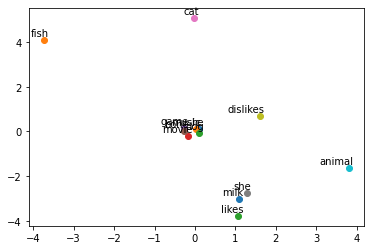

In [204]:
# Get the trained projection matrix
trained_embeddings = model.linear1.weight.view(13,2).data.numpy()
# Visualise result
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    # print (label, " : ", x, " " , y) # uncomment to see the detailed vector info
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

In [165]:
#no
inputs_torch.shape#torch.Size([16, 2, 13])--- #希望这里是【16，13】
labels_torch.shape  #torch.Size([16])  
log_softmax.shape#torch.Size([16, 2, 13])

torch.Size([16, 2, 13])

In [169]:

'''
for ind in range(0,len(cbow),batch_size):     #ind: 0,16,32
  data_temp = cbow[ind : min(ind+batch_size,len(cbow))]  #batch每次录入三个
  
  inputs_temp, labels_temp = prepare_batch(data_temp)
#pprint.pprint(data_temp)##batch 是16么内容应该是16
#pprint.pprint(labels_temp) #array([ 9, 12,  0,  3,  0,  2,  6,  0,  6,  2,  8, 12,  6, 11,  7,  5])
#pprint.pprint(inputs_temp)#16个 两个内容词

  inputs_torch = torch.from_numpy(inputs_temp).float()
  labels_torch = torch.from_numpy(labels_temp)

  log_softmax = F.log_softmax(model.forward(inputs_torch),dim = 1)
  loss = F.nll_loss(log_softmax, labels_torch)


  
  loss.backward()
  with torch.no_grad():
      W1.data -= learning_rate*W1.grad.data
      Wout.data -= learning_rate*Wout.grad.data
  W1.grad.data.zero_()
  Wout.grad.data.zero_()

  loss_sum += loss.item()

if epoch % 500 == 499: 
    print('Epoch: %d, loss: %.4f' %(epoch + 1, loss_sum))

'''



In [171]:
    #input = model.forward(inputs_torch)
'''
print(inputs_torch)
print(inputs_torch[:,0,:])
print(inputs_torch[:,1])
'''
  #print(input[:,0])
  #print(input[0])
'''

[:,:,0]
取三维数组中第1列的所有楼层，所有行的数据
#https://blog.csdn.net/u014159143/article/details/80307717?ops_request_misc=&request_id=&biz_id=102&utm_term=python%20%5B%20：，0，：%5D什么意思&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-4-80307717.first_rank_v2_pc_rank_v29

'''

'\n\n[:,:,0]\n取三维数组中第1列的所有楼层，所有行的数据\n#https://blog.csdn.net/u014159143/article/details/80307717?ops_request_misc=&request_id=&biz_id=102&utm_term=python%20%5B%20：，0，：%5D什么意思&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-4-80307717.first_rank_v2_pc_rank_v29\n\n'

In [84]:
ind+batch_size
#min(0+16, 48 )--16_____0---16
#(16+16,48)32-______16-32
#32+16,48 48____32---48

#https://blog.csdn.net/wangchuner/article/details/102829111?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522161684141016780265451641%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=161684141016780265451641&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_v2~rank_v29-2-102829111.first_rank_v2_pc_rank_v29&utm_term=如何调用类里面的函数+python


48

In [ ]:
#optim
#https://blog.csdn.net/nineship/article/details/89228497?ops_request_misc=&request_id=&biz_id=102&utm_term=torch.optim%20怎么用&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-4-89228497.first_rank_v2_pc_rank_v29